In [ ]:
#Gently and friendly reminder: please do NOT use the code that is all over the internet :)

In [ ]:
"""
The float variables will be gridded at unit intervals, so generalization
will be by approximately 1 in each direction, and any scaling will have 
to be done externally before calling tiles.

Num-tilings should be a power of 2, e.g., 16. To make the offsetting work properly, it should
also be greater than or equal to four times the number of floats.

The first argument is either an index hash table of a given size (created by (make-iht size)), 
an integer "size" (range of the indices from 0), or nil (for testing, indicating that the tile 
coordinates are to be returned without being converted to indices).
"""

basehash = hash

class IHT:
    "Structure to handle collisions"
    def __init__(self, sizeval):
        self.size = sizeval                        
        self.overfullCount = 0
        self.dictionary = {}

    def __str__(self):
        "Prepares a string for printing whenever this object is printed"
        return "Collision table:" + \
               " size:" + str(self.size) + \
               " overfullCount:" + str(self.overfullCount) + \
               " dictionary:" + str(len(self.dictionary)) + " items"

    def count (self):
        return len(self.dictionary)
    
    def fullp (self):
        return len(self.dictionary) >= self.size
    
    def getindex (self, obj, readonly=False):
        d = self.dictionary
        if obj in d: return d[obj]
        elif readonly: return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfullCount==0: print('IHT full, starting to allow collisions')
            self.overfullCount += 1
            return basehash(obj) % self.size
        else:
            d[obj] = count
            return count

def hashcoords(coordinates, m, readonly=False):
    if type(m)==IHT: return m.getindex(tuple(coordinates), readonly)
    if type(m)==int: return basehash(tuple(coordinates)) % m
    if m==None: return coordinates

from math import floor, log
from itertools import zip_longest

def tiles (ihtORsize, numtilings, floats, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append( (q + b) // numtilings )
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

def tileswrap (ihtORsize, numtilings, floats, wrapwidths, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints, wrapping some floats"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q, width in zip_longest(qfloats, wrapwidths):
            c = (q + b%numtilings) // numtilings
            coords.append(c%width if width else c)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

In [ ]:
import gym
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
env = gym.make('MountainCar-v0')


In [ ]:
# Tile Coding Function
class MountainCarTileCoder:
    def __init__(self, iht_size, num_tilings, num_tiles):
        """
        Initializes the MountainCar Tile Coder
        *Initializers: 
        iht_size(int): the size of the index hash table, typically a power of 2. 4096 in this question.
        num_tilings(int): the number of tilings
        num_tiles(int: the number of tiles. Here both the width and height of the tile coder are the same

        *Class Variables:
        self.iht(tc.IHT): the index hash table that the tile coder will use, better understood after reviewing the link provided in the question
        self.num_tilings(int): the number of tilings the tile coder will use
        self.num_tiles(int): the number of tiles the tile coder will use
        """
        self.iht_size = iht_size
        self.iht = IHT(iht_size)
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles
    
    def get_tiles(self, position, velocity):
        """
        Takes in a position and velocity from the mountaincar environment
        and returns a numpy array of active tiles.
        
        Arguments:
        position(float): the position of the agent 
        velocity(float): the velocity of the agent 
        returns:
        tiles - np.array, active tiles
        """
        # Set the max and min of position and velocity to scale the input     
        # Use the ranges above and self.num_tiles to set position_scale and velocity_scale
        # Scale position and velocity by multiplying the inputs of each by their scale
        # get the tiles using tc.tiles, with self.iht, self.num_tilings and [scaled position, scaled velocity]

        minimum_p = -1.2 # minimum position 
        maximum_p = 0.5
        maximum_v = -0.07 # maximum velocity 
        minimum_v = 0.07

        position_scaled = (self.num_tiles / (maximum_p - minimum_p)) * position
        velocity_scaled = (self.num_tiles / (maximum_v - minimum_v)) * velocity

        active_tiles = tiles(self.iht, self.num_tilings, [position_scaled, velocity_scaled])
        
        return np.array(active_tiles)

In [ ]:
class Agent():
    def __init__(self,  environment, tile_coding , discount=1  , learning_rate = 0.01 , epsilon = 0 ):

        self.environment = environment 
        self.discount = discount # discount factor
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.n_actions = env.action_space.n  # action space of environment
        self.iht_size = tile_coding.iht_size  # size of the index hash table of the tile coding
        self.weights = np.zeros((self.n_actions , self.iht_size)) # Initial weights of the agent 
        self.tile_coding = tile_coding  # The type of tile coding we're utilizing

    def run_episode(self , weights , done = False):

        n_steps = 0   # number of steps taken until the end of the episode
        state = env.reset()  
        phi_s , active_tiles = self.get_phi_s( state)  # state coding and active tiles of the agent in state S
        # The action selected by epsion-greedy policy and it's corresponding value:
        current_action , current_action_val = self.select_action( phi_s , weights) 

        while not done: # agent lives in the environment until it reaches a Terminal state
            phi_s , active_tiles= self.get_phi_s( state)
            # Take a step in the environment and observe R and S'
            next_state, reward, done, info = env.step(current_action) 
            n_steps += 1 # increment steps after taking each step
            # If the agent reaches the Terminal state (Flag or max_iteration)

            if done:
                grad = np.array([1] * len(active_tiles)) # gradient of value function
                TD_error = reward - current_action_val  

                weights[current_action][active_tiles] = weights[current_action][active_tiles] + self.learning_rate * TD_error * grad

            else:
                # obtain next_action (A') and Q value (Q(S',A',theta)) to calculate TD_target
                next_phi_s , _= self.get_phi_s( next_state)
                next_action , next_action_value = self.select_action( next_phi_s , weights)
                self.discount = 1
                TD_target = reward + (self.discount * next_action_value)
                _ , current_action_val = self.select_action( phi_s , weights)
                TD_error = TD_target - current_action_val
                grad = np.array([1] * len(active_tiles))            
                weights[current_action][active_tiles] = weights[current_action][active_tiles] + self.learning_rate * TD_error * grad

            current_action = next_action
            state = next_state
            
        return weights , n_steps

    def select_action(self , phi_s , weight): 
        actions = list(range(self.n_actions))
        action_values = [np.dot(weight[action] , phi_s) for action in actions] #list of Q(S,A,theta) for every action
        A_star = action_values.index(max(action_values)) # A = argmax Q(S,A,theta)
        policy = ['greedy' , 'random'] 
        policy = random.choices(policy, weights=[1-self.epsilon , self.epsilon] )[0]
        if policy == 'greedy':
           Q_value = action_values[A_star] # Q(S , A , theta)
           return A_star , Q_value
        else:
           A_t = random.choice(actions)
           Q_value = action_values[A_t] # Q(S , A , theta)
           return A_t , Q_value 

    def get_phi_s(self , state):
        position, velocity = state
        active_tiles = self.tile_coding.get_tiles(position = position, velocity = velocity)
        phi_s = np.zeros((self.iht_size))
        np.put(phi_s, active_tiles , 1)

        return phi_s , active_tiles


In [ ]:
def plot_steps( steps , epsisodes):
    fig = plt.figure()
    from matplotlib.pyplot import figure
    figure(figsize=(15, 10), dpi=100)
    smoothing_window=10
    steps_average = np.mean(np.array(steps[0]), axis=0)
    steps_smoothed_first = pd.Series(steps_average).rolling(smoothing_window, min_periods=smoothing_window).mean()
    steps_average = np.mean(np.array(steps[1]), axis=0)
    steps_smoothed_second = pd.Series(steps_average).rolling(smoothing_window, min_periods=smoothing_window).mean()
    steps_average = np.mean(np.array(steps[2]), axis=0)
    steps_smoothed_third = pd.Series(steps_average).rolling(smoothing_window, min_periods=smoothing_window).mean()

    plt.plot(list(range(epsisodes)) , steps_smoothed_first, label ='First Tile coding')
    plt.plot(list(range(epsisodes)) , steps_smoothed_second, label ='Second Tile Coding')
    plt.plot(list(range(epsisodes)) , steps_smoothed_third, label ='Third Tile Coding')

    plt.grid(axis='y' , color='lightgrey')
    plt.title("Average steps ", fontsize=16)

    plt.xlabel("Episode", fontsize=18)
    plt.ylabel("Iteration ", fontsize=16)
    plt.legend(loc="upper right", prop={'size': 14})
    plt.show()


In [ ]:
def start_learning(agent , environment  , Runs = 20 , episodes = 500):
    EPISODES = episodes
    env.reset()
 
    every_steps = [] # a list to store the list of steps taken in each run
    for r in range(Runs): 

        state = env.reset() # Resets environment
        weights = np.zeros((environment.action_space.n , agent.iht_size)) # initial weights
        steps_per_episode = []

        for e in range(episodes):
            # Print out which episode we're on
            if (e + 1) % 10 == 0:
                print("\rEpisode {}/{}. Run {}/{}".format(e + 1, episodes , r+1 , Runs), end="")
            
            weights , n_steps = agent.run_episode( weights , done = False)       
            steps_per_episode.append(n_steps) # add taken steps in the episode to the list

        # Create an array of steps_per_episode 
        every_steps.append(np.array(steps_per_episode))  

    env.close() 

    return every_steps

# Tile Codings

In [ ]:
First_tile_coding = MountainCarTileCoder(iht_size = 4096 , num_tilings = 2 ,num_tiles= 16 )
Second_tile_coding = MountainCarTileCoder(iht_size = 4096 ,num_tilings = 32 , num_tiles = 4)
Third_tile_coding = MountainCarTileCoder(iht_size = 4096 ,num_tilings = 8 , num_tiles = 8)

## Learning with First tile coding

In [ ]:
EPISODES = 500
agent = Agent(env , First_tile_coding ,discount = 1 , learning_rate = 0.25 , epsilon= 0 )

all_steps_first = start_learning(agent=agent , environment=env , Runs =20 , episodes = EPISODES)

Episode 500/500. Run 20/20

## Learning with second tile coding

In [ ]:
EPISODES = 500
agent = Agent(env , Second_tile_coding ,discount = 1 , learning_rate = 0.01 , epsilon= 0 )

all_steps_second = start_learning(agent=agent , environment=env ,Runs = 20 , episodes = EPISODES)

Episode 500/500. Run 20/20

## Learning with third tile coding

In [ ]:
EPISODES = 500
agent = Agent(env , Third_tile_coding ,discount = 1 , learning_rate = 0.1 , epsilon= 0)
all_steps_third = start_learning(agent=agent , environment=env ,Runs = 20 , episodes = EPISODES)


Episode 500/500. Run 20/20

# Plot average steps

<Figure size 432x288 with 0 Axes>

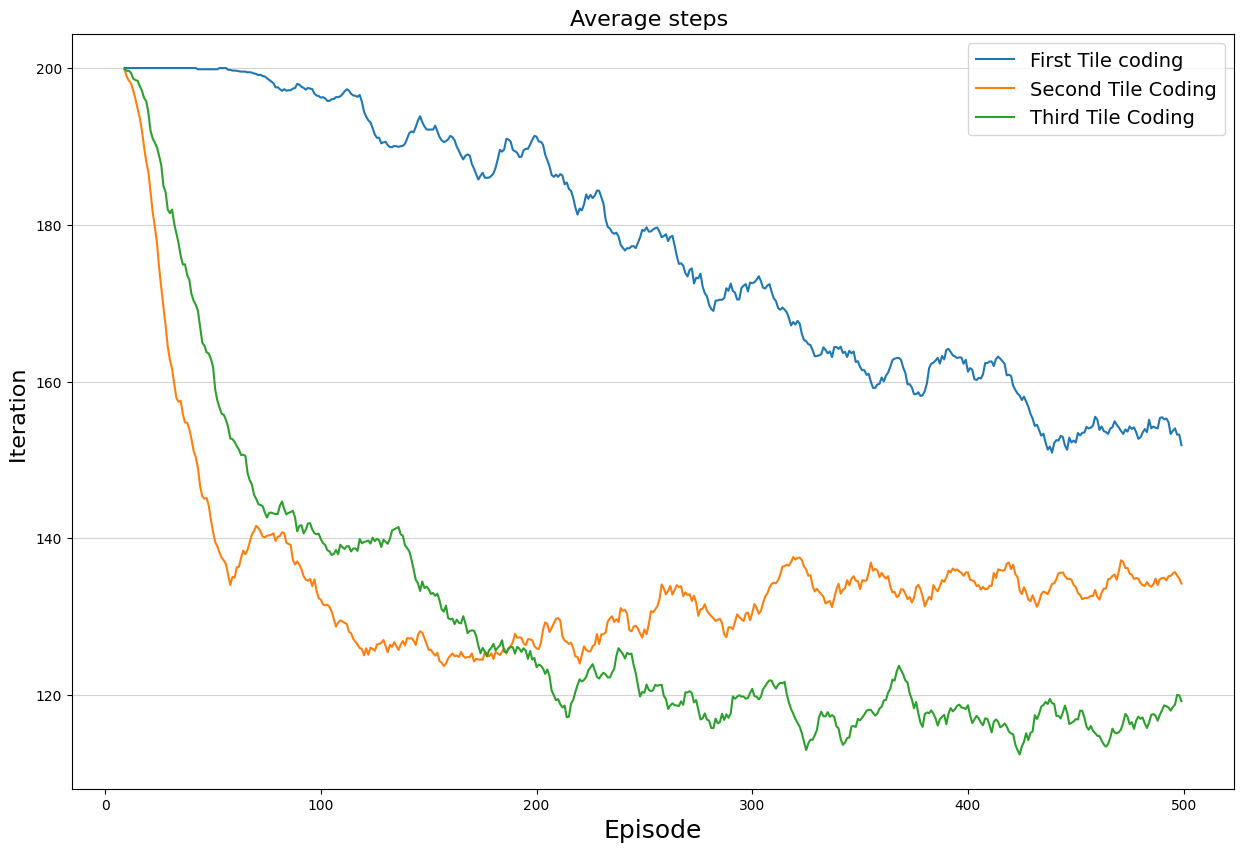

In [ ]:
all_steps = [ all_steps_first ,  all_steps_second , all_steps_third]
plot_steps(all_steps , EPISODES)